## Week 5 Assignment - Data Exploration and Maps for Group Project
### Creating map of LA Metro+LADOT+Big Blue Bus stops, as well as LA Metro Rail stops overlaid on senior density.
#### Carolyn Pugh

### Import Libraries

In [1]:
#import the libraries I will be using below (pandas, geopandas, matplotlib, contextily)
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import requests
import urllib

### LA City Blockgroup Boundaries

First, I need to import two files containing relevant spatial data - a geojson file showing the boundaries of the City of Los Angeles, since that is our geographic focus. Next, a geojson file that contains block groups for the entire County of Los Angeles, since the file with the City boundary does not contain the block group information.

In [2]:
#reading in the two spatial files and naming dataframes
city_bound = gpd.read_file('City_Boundaries.geojson')
#city_bound has the boundaries of all cities in LA County
blockgroups = gpd.read_file('Census_Block_Groups_2020.geojson')
#blockgroups has hte blockgroup boundaries for all of LA County

The "city_bound" dataframe has all city boundaries in LA, and I only want to look at the City of LA (not Santa Monica, for example). Therefore I only want a subset of this dataframe.

In [3]:
#Querying the city boundary dataframe to create a new LA only boundary.
city_boundLA = city_bound.query("CITY_NAME == 'Los Angeles'").copy()

Next, I will use the "city_boundLA" dataframe to "clip" the LA county blockgroups dataframe, creating a new dataframe that contains blockgroup information for only LA city.

In [4]:
#Using "clip" to create a mask of the block boundary data and cut out everything that is outside LA city.
cityblockgroups = gpd.clip(blockgroups,city_boundLA)

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

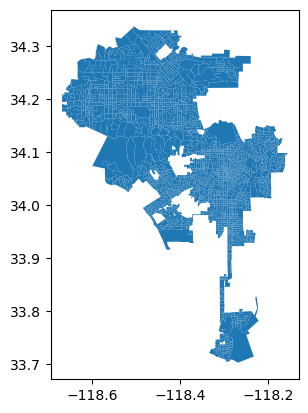

In [5]:
#Plotting the newly created clipped dataframe.
cityblockgroups.plot()

In [6]:
# Save this file because it may be useful for other scripts.
cityblockgroups.to_file('cityblockgroups.geojson')

### Read in LA Metro Bus Route Data

In [7]:
#read in Metro bus lines geojson file and create dataframe
metrobusroute = gpd.read_file('Metro_Bus_Lines.geojson')

In [8]:
#What columns does it have?
metrobusroute.columns.to_list()

['OBJECTID',
 'VAR_ROUTE',
 'VAR_IDENT',
 'VAR_DESCR',
 'VAR_DIREC',
 'MetroCategory',
 'MetroBusType',
 'RouteNumber',
 'RouteName',
 'TOOLTIP',
 'NLA_URL',
 'geometry']

I will rename some of these columns to make it more obvious what they represent.

In [9]:
#Renaming columns for clarity
metrobusroute.rename(columns=
               {'VAR_ROUTE':'Trunk Line',
 'VAR_IDENT':'Identifying Number',
 'VAR_DESCR':'Trip Pattern',
 'MetroCategory': 'Metro Category',
 'MetroBusType':'Metro Bus Type',
 'RouteNumber': 'Route Number',
 'RouteName': 'Route Name'}, inplace = True)
#Displaying first 2 rows as a check
metrobusroute.head(2)

,OBJECTID,Trunk Line,Identifying Number,Trip Pattern,VAR_DIREC,Metro Category,Metro Bus Type,Route Number,Route Name,TOOLTIP,NLA_URL,geometry
0,1,603,N1,END TO END,0,ComCirc,Metro Shuttles and Circulators,603,603 Glendale-Grand Sta Via San Fernando-Rampar...,603 Glendale-Grand Sta Via San Fernando-Rampar...,http://www.metro.net/riding/maps/?nla_target=1...,"LINESTRING (-118.26462 34.03322, -118.26432 34..."
1,2,603,S1,END TO END,1,ComCirc,Metro Shuttles and Circulators,603,603 Glendale-Grand Sta Via San Fernando-Rampar...,603 Glendale-Grand Sta Via San Fernando-Rampar...,http://www.metro.net/riding/maps/?nla_target=1...,"LINESTRING (-118.26088 34.14528, -118.26088 34..."


### Read in LA Metro Bus Stop Data - "Stops Serving Lines"
#### Each stop contains data for each line served by that stop. This will be important for our analysis of what stops are accessible to block groups with high densities of senior residents.

In [10]:
#Read in file for LA Metro Bus Stops and name a new dataframe, metrobusstops
metrobusstops = gpd.read_file('StopServingLines1022.shp')

In [11]:
#Renaming columns for clarity
metrobusstops.rename(columns=
               {'STOPNUM':'StopNumber',
 'STOPNAME':'StopName'}, inplace = True)
#Displaying first 5 rows as a check
metrobusstops.head()

,StopNumber,StopName,LAT,LONG,LINE_DIR1,LINE_DIR2,LINE_DIR3,LINE_DIR4,LINE_DIR5,LINE_DIR6,LINE_DIR7,LINE_DIR8,LINE_DIR9,LINE_DIR10,LINE_DIR11,LINE_DIR12,LINE_DIR13,LINE_DIR14,geometry
0,1,Paramount / Slauson,33.973248,-118.113113,108-E,265-S,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.11311 33.97325)
1,3,Jefferson / 10th,34.025471,-118.328402,35-N,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.32840 34.02547)
2,6,120th / Augustus F Hawkins,33.924696,-118.242222,53-N,120-W,55-N,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.24222 33.92470)
3,7,120th / Martin Luther King Hospital,33.924505,-118.240369,55-S,120-E,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.24037 33.92451)
4,12,15054 Sherman Way,34.201075,-118.461953,162-E,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.46195 34.20108)


### Pulling in LA DOT Bus Route and Stop Data

LA DOT provided data in six shapefiles, one file for routes and one for stops for three different bus types

LA DOT Community Dash:

In [12]:
#Read in file for LA DOT Community Dash Bus Stops and Routes
communitydash_stops = gpd.read_file('LA_DOT_data/geo_export_16a65b67-8914-4be6-b080-e03f9fdd23a6.shp')
communitydash_route = gpd.read_file('LA_DOT_data/geo_export_6a5115bd-2818-4cdd-bd10-d8ea258b75b7.shp')

In [13]:
#first row of community dash stop as check
communitydash_stops.head(1)

,nla_url,region,regiontype,routeid,routename,routenames,stopid,stopname,stopnumber,tooltip,geometry
0,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,89.0,Beachwood Canyon,BC,298831.0,Beachwood & Westshire (Southbound),2401.0,Stop: Beachwood & Westshire (Southbound)\nStop...,POINT (-118.32111 34.11968)


<AxesSubplot: >

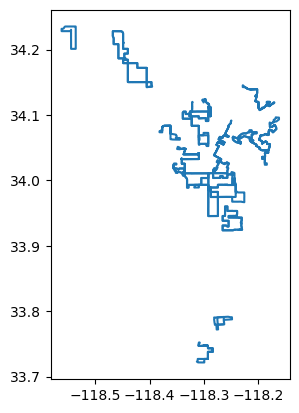

In [14]:
#plot routes for community dash as check
communitydash_route.plot()

LA DOT Commuter Express:

In [15]:
#Read in file for LA DOT Commuter Express Bus Stops and Routes
commuterexpress_route = gpd.read_file('LA_DOT_data/geo_export_1b588cc2-b98f-42a6-8207-e6df6af67c22.shp')
commuterexpress_stops = gpd.read_file('LA_DOT_data/geo_export_6d784597-ba4b-4a1a-8e74-4ca9e9758280.shp')

<AxesSubplot: >

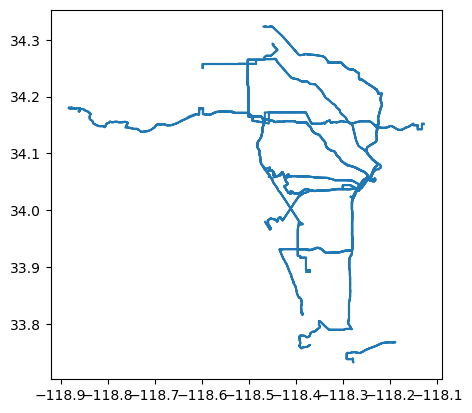

In [16]:
#plot routes for Commuter Express as check
commuterexpress_route.plot()

In [17]:
#first row of Commuter Express stop as check
commuterexpress_stops.head(1)

,nla_url,region,regiontype,routeid,routename,routenames,stopid,stopname,stopnumber,tooltip,geometry
0,http://www.ladotbus.com/simple/regions/8/route...,8.0,Commuter Express,12.0,CE142 - Long Beach,CE142 - Long Beach,431166.0,Ports O'Call & Sampson Way,8800.0,Stop: Ports O'Call & Sampson Way\nStop No: 880...,POINT (-118.27780 33.73204)


LA DOT Downtown DASH

In [18]:
#Read in file for LA DOT downtown dash files
downtowndash_route = gpd.read_file('LA_DOT_data/geo_export_247776de-aafe-44c0-9cbd-03d1931ad720.shp')
downtowndash_stops = gpd.read_file('LA_DOT_data/geo_export_d09ae2e0-bede-462e-996d-3f4e9eb096e2.shp')

In [19]:
#first row of downtown dashs stop as check
downtowndash_stops.head(1)

,nla_url,region,regiontype,routeid,routename,routenames,stopid,stopname,stopnumber,tooltip,geometry
0,http://www.ladotbus.com/simple/regions/6/route...,6.0,Downtown Dash,40.0,Route A,A,91421.0,7th & Bixel (Westbound),6153.0,Stop: 7th & Bixel (Westbound)\nStop No: 6153\n...,POINT (-118.26400 34.05081)


<AxesSubplot: >

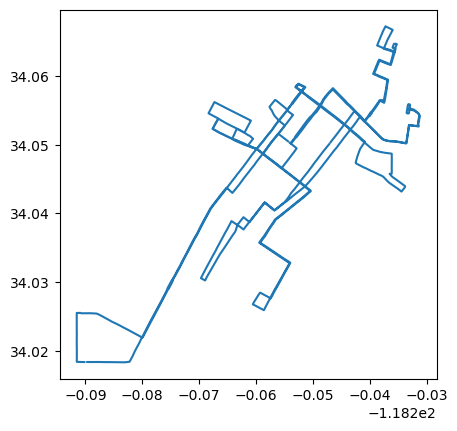

In [20]:
#plot routes for downtown dash as check
downtowndash_route.plot()

### Getting Big Blue Bus Data

In [21]:
#read in shapefile and create dataframe
BBB_stops = gpd.read_file('BigBlueBusdata/stops.shp')
#print first row as check
BBB_stops.head(1)

,stop_id,stop_code,stop_name,stop_desc,geometry
0,1145,2768,SUNSET EB & MARQUEZ PL FS,17100 W SUNSET BLVD & MARQUEZ AVE,POINT (-118.54889 34.04185)


<AxesSubplot: >

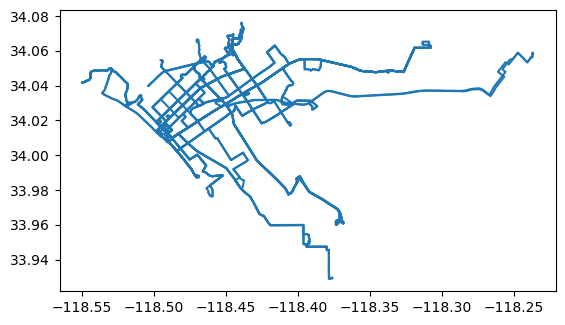

In [22]:
#read in routes shapefile and create dataframe
BBB_routes = gpd.read_file('BigBlueBusdata/shapes.shp')
#plot as check
BBB_routes.plot()

### Clipping Dataframes to get only LA City

I will use the LA city boundary dataframe to create new dataframes for both bus routes and bus stops that are specific to the City.

In [23]:
#Using "clip" to create a mask of the city boundary data and cut out bus stops that are outside the LA city boundary.
citymetrostops = gpd.clip(metrobusstops,city_boundLA)

In [24]:
#Using "clip" to create a mask of the city boundary data and cut out bus route data that is outside the LA city boundary.
citybusroute = gpd.clip(metrobusroute,city_boundLA)

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [25]:
#First I need to edit the CRS of LA DOT datasets to match that of the rest of my datasets.
communitydash_stops = communitydash_stops.to_crs(4326)
communitydash_route = communitydash_route.to_crs(4326)
commuterexpress_route = commuterexpress_route.to_crs(4326)
commuterexpress_stops = commuterexpress_stops.to_crs(4326)
downtowndash_route = downtowndash_route.to_crs(4326)
downtowndash_stops = downtowndash_stops.to_crs(4326)

In [26]:
#Clipping community DASH bus dataframes to include only LA City
community_citydot_stops = gpd.clip(communitydash_stops,city_boundLA)
community_citydot_route = gpd.clip(communitydash_route,city_boundLA)
#Clipping Commuter DASH bus dataframes to include only LA City
commuter_citydot_route = gpd.clip(commuterexpress_route,city_boundLA)
commuter_citydot_stops = gpd.clip(commuterexpress_stops,city_boundLA)
#Clipping Downtown DASH bus dataframes to include only LA City
downtown_citydot_route = gpd.clip(downtowndash_route,city_boundLA)
downtown_citydot_stops = gpd.clip(downtowndash_stops,city_boundLA)

In [27]:
#Clipping Big Blue Bus dataframe to include only LA city stops
BBB_stops_city = gpd.clip(BBB_stops, city_boundLA)
BBB_routes_city = gpd.clip(BBB_routes, city_boundLA)

### Plotting Bus Stops with Density of Seniors

I want to make a map that overlays LA Metro, LA DOT, and Big Blue Bus Stops over a base map of density of seniors in the City of LA. 

In [28]:
#Pull in the senior population density dataframe from Lucy's data cleaning work.
seniors=gpd.read_file('Senior_Pop_Density.geojson')
seniors.head()

,BG20,ShapeSTArea,FIPS,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Square Miles,Pop Density,geometry
0,2742023,1.045276e+06,060372742023,0,0,13,13,0.403581,32.0,"POLYGON ((-118.46464 33.97641, -118.46508 33.9..."
1,2739025,5.131686e+06,060372739025,120,38,0,158,1.981346,80.0,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713..."
2,2739024,1.861628e+06,060372739024,90,10,0,100,0.718775,139.0,"POLYGON ((-118.46565 33.97974, -118.46587 33.9..."
3,2739023,1.218168e+06,060372739023,92,137,11,240,0.470335,510.0,"POLYGON ((-118.46315 33.98615, -118.46310 33.9..."
4,2735023,4.868382e+06,060372735023,29,40,0,69,1.879684,37.0,"POLYGON ((-118.47672 33.98746, -118.47506 33.9..."


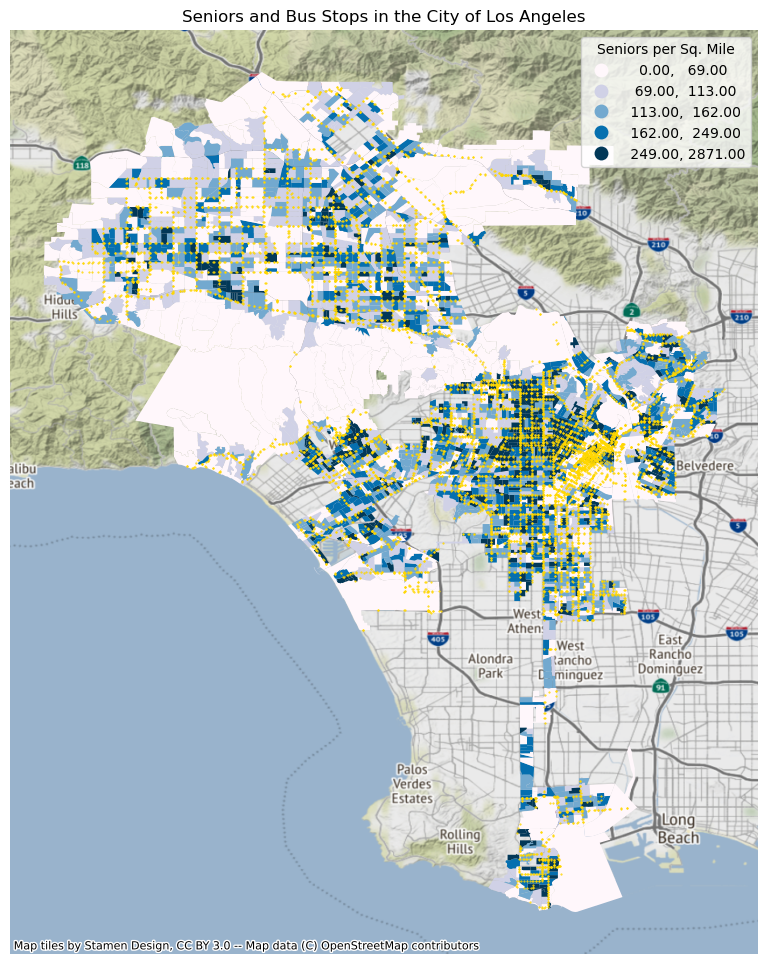

In [29]:
#Plot Bus Stops on top of Senior Population Density
fig,ax = plt.subplots(figsize=(12,12))
ax1=seniors.plot(ax=ax,column='Pop Density',scheme='quantiles',legend=True,cmap='PuBu',
              legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
               'title': 'Seniors per Sq. Mile'
            }),
#plot LA metro bus stops
ax2=citymetrostops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold')
#plot LA DOT bus stops
ax3=community_citydot_stops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold')
ax3=commuter_citydot_stops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold') 
ax3=downtown_citydot_stops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold') 
ax4 = BBB_stops_city.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold') 

#Format plot.
ax.axis('off')
ax.set_title('Seniors and Bus Stops in the City of Los Angeles')
ctx.add_basemap(ax, crs=4326)





### Plotting all Public Transit Stops Over Density of Seniors

Import LA metro stop data

In [30]:
#import the Data 
metrorailstops = gpd.read_file('MetroRailStopsdata/Metro_Rail_Lines_Stops.geojson')
#clip to city boundaries
citymetrorailstops = gpd.clip(metrorailstops,city_boundLA)

Recreate plot including metro stops to get a map of Public Transit Stops in LA City overlaid on density of seniors

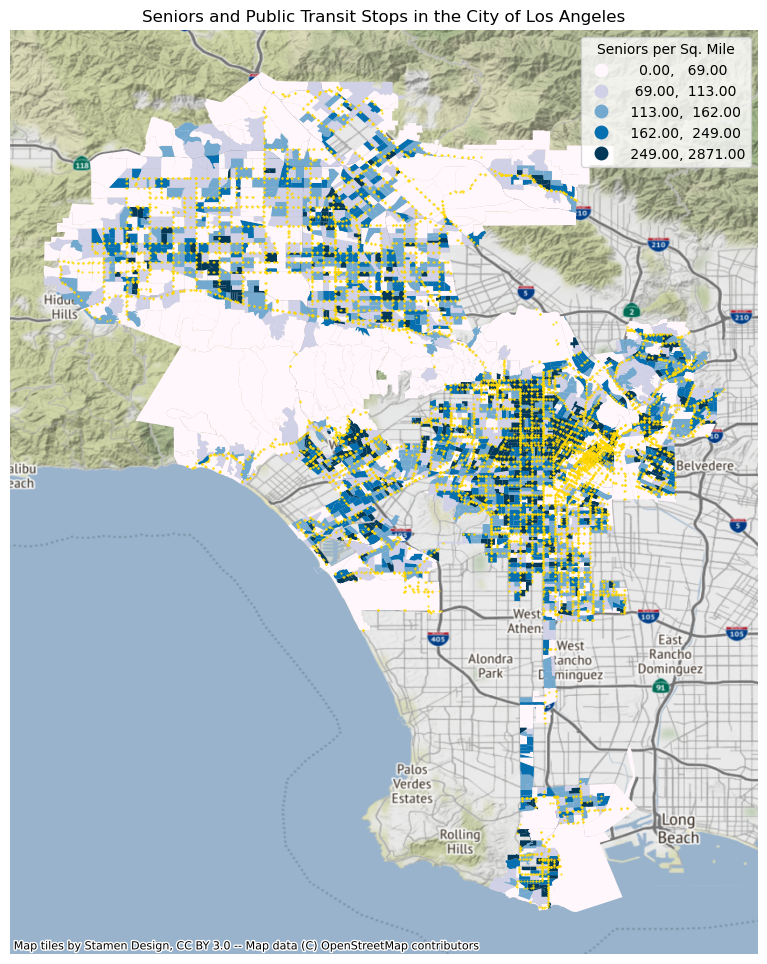

In [31]:
#Plot Bus Stops and Metro Stops on top of Senior Population Density
fig,ax = plt.subplots(figsize=(12,12))
ax1=seniors.plot(ax=ax,column='Pop Density',scheme='quantiles',legend=True,cmap='PuBu',
              legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
               'title': 'Seniors per Sq. Mile'
            }),
#plot LA metro bus stops
ax2=citymetrostops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold')
#plot LA DOT bus stops
ax3=community_citydot_stops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold')
ax3=commuter_citydot_stops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold') 
ax3=downtown_citydot_stops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold') 
ax4 = BBB_stops_city.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold') 
ax4 = citymetrorailstops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold') 

#Format plot.
ax.axis('off')
ax.set_title('Seniors and Public Transit Stops in the City of Los Angeles')
ctx.add_basemap(ax, crs=4326)


### Now I will create a dataframe with all bus and metro stops.

Let's start with LA DOT, and combine the different dataframes. 

In [32]:
#try to create dataframe with all the transit stop data, starting with LA DOT
#append community dash to commuter express and create new dataframe
data = [community_citydot_stops, commuter_citydot_stops]
df2 = pd.concat(data)
#append downtown dash to new dataframe
data2 = [df2, downtown_citydot_stops]
LADOTcitystops = pd.concat(data2)
#check by displaying sample rows
LADOTcitystops.sample(6)

,nla_url,region,regiontype,routeid,routename,routenames,stopid,stopname,stopnumber,tooltip,geometry
363,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,89.0,Highland Park / Eagle Rock,HP,303142.0,Figueroa & Ave. 60 (Eastbound),2764.0,Stop: Figueroa & Ave. 60 (Eastbound)\nStop No:...,POINT (-118.18882 34.11142)
55,http://www.ladotbus.com/simple/regions/8/route...,8.0,Commuter Express,12.0,CE409A - Sylmar,CE409A - Sylmar,433634.0,Flower St & 5th St,6021.0,Stop: Flower St & 5th St\nStop No: 6021\nRoute...,POINT (-118.25659 34.05103)
799,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,89.0,Lincoln Heights / Chinatown Counter-clockwise,LHCC,305792.0,Broadway & Bernard St.,2180.0,Stop: Broadway & Bernard St.\nStop No: 2180\nR...,POINT (-118.23579 34.06692)
204,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,10.0,El Sereno / City Terrace,El Sereno,353569.0,Huntington Dr & Lowell Ave (Westbound),4245.0,Stop: Huntington Dr & Lowell Ave (Westbound)\n...,POINT (-118.16198 34.09292)
60,http://www.ladotbus.com/simple/regions/8/route...,8.0,Commuter Express,12.0,CE409A - Sylmar,CE409A - Sylmar,433870.0,7th St & Hill St (Westbound),6115.0,Stop: 7th St & Hill St (Westbound)\nStop No: 6...,POINT (-118.25472 34.04617)
1351,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,11.0,Van Nuys/Studio City Clockwise,VN/SC CW,391608.0,Whitsett Ave & Addison St Southbound,3241.0,Stop: Whitsett Ave & Addison St Southbound\nSt...,POINT (-118.40533 34.16166)


This looks good. Now I will try to combine it with Big Blue Bus data. I need to think about what columns does Big Blue Bus data have, how does it compare to LADOT, and what do I need from each?

In [33]:
#what columns does Big Blue Bus data have, how does it compare to LADOT, and what do I need from each?
BBB_stops_city

,stop_id,stop_code,stop_name,stop_desc,geometry
102,38,2010,AVIATION/LAX STATION,11600 UNNAMED ST,POINT (-118.37625 33.92950)
82,529,2187,AVIATION NB & IMPERIAL FS,11300 AVIATION BLVD & E IMPERIAL HWY,POINT (-118.37838 33.93121)
194,616,2238,CENTURY EB & AVIATION NS,5500 W CENTURY BLVD & LOS ANGELES COUNTY METRO...,POINT (-118.37904 33.94538)
748,532,2190,CENTURY WB & AVIATION FS,5600 W CENTURY BLVD & LOS ANGELES COUNTY METRO...,POINT (-118.37883 33.94564)
618,1671,3112,98TH EB & AVION FS,0 W 98TH ST & AVION DR,POINT (-118.38964 33.94728)
...,...,...,...,...,...
722,1099,2552,BARRINGTON NB & TERRYHILL FS,600 S BARRINGTON AVE & TERRYHILL PL,POINT (-118.46819 34.05812)
626,1101,2554,BARRINGTON SB & 400 BK (REC CTR) MB,400 S BARRINGTON AVE & BARRINGTON CT,POINT (-118.46861 34.06162)
625,1100,2553,BARRINGTON NB & 400 BL (REC CTR) NS,400 S BARRINGTON AVE & BARRINGTON CT,POINT (-118.46847 34.06227)
191,140,2048,BARRINGTON SB & SUNSET FS,100 S BARRINGTON AVE & BARRINGTON CT,POINT (-118.46966 34.06479)


For the purposes of this exercise, I really only need stop name, stop ID, and geometry. 

Refining columns for LADOT data:

In [34]:
#get column names
LADOTcitystops.columns.to_list()

['nla_url',
 'region',
 'regiontype',
 'routeid',
 'routename',
 'routenames',
 'stopid',
 'stopname',
 'stopnumber',
 'tooltip',
 'geometry']

In [35]:
#list columns to keep
columnstokeep = ['stopid','stopname','geometry']
#create new dataframe
LADOTcitystops1 = LADOTcitystops[columnstokeep]
#print
LADOTcitystops1

,stopid,stopname,geometry
1632,355358.0,Anaheim St & Fries Ave (Eastbound),POINT (-118.26526 33.77972)
1600,354962.0,Anaheim St & Fries Ave (Westbound),POINT (-118.26511 33.77990)
1599,354957.0,Anaheim St & Avalon Blvd (Westbound),POINT (-118.26279 33.78001)
1633,355370.0,Avalon Blvd & Anaheim St (Northbound),POINT (-118.26237 33.78030)
1634,355380.0,Avalon Blvd & Opp St (Northbound),POINT (-118.26256 33.78272)
...,...,...,...
60,42384.0,Chinatown Gold Line Station (Westbound),POINT (-118.23595 34.06367)
61,42387.0,Hill & College,POINT (-118.23858 34.06469)
64,42392.0,Broadway & Gin Ling Way,POINT (-118.23686 34.06529)
62,42388.0,Hill & Gin Ling Way,POINT (-118.23805 34.06577)


Refining columns for Big Blue Bus

In [36]:
#list columns to keep
columnstokeep1 = ['stop_id','stop_name','geometry']
#create new dataframe
BBB_stops_city1 = BBB_stops_city[columnstokeep1]
#print
BBB_stops_city1

,stop_id,stop_name,geometry
102,38,AVIATION/LAX STATION,POINT (-118.37625 33.92950)
82,529,AVIATION NB & IMPERIAL FS,POINT (-118.37838 33.93121)
194,616,CENTURY EB & AVIATION NS,POINT (-118.37904 33.94538)
748,532,CENTURY WB & AVIATION FS,POINT (-118.37883 33.94564)
618,1671,98TH EB & AVION FS,POINT (-118.38964 33.94728)
...,...,...,...
722,1099,BARRINGTON NB & TERRYHILL FS,POINT (-118.46819 34.05812)
626,1101,BARRINGTON SB & 400 BK (REC CTR) MB,POINT (-118.46861 34.06162)
625,1100,BARRINGTON NB & 400 BL (REC CTR) NS,POINT (-118.46847 34.06227)
191,140,BARRINGTON SB & SUNSET FS,POINT (-118.46966 34.06479)


In [37]:
#rename columns to match LADOT
BBB_stops_city1 = BBB_stops_city1.rename(columns={'stop_id': 'stopid', 'stop_name': 'stopname'})
BBB_stops_city1

,stopid,stopname,geometry
102,38,AVIATION/LAX STATION,POINT (-118.37625 33.92950)
82,529,AVIATION NB & IMPERIAL FS,POINT (-118.37838 33.93121)
194,616,CENTURY EB & AVIATION NS,POINT (-118.37904 33.94538)
748,532,CENTURY WB & AVIATION FS,POINT (-118.37883 33.94564)
618,1671,98TH EB & AVION FS,POINT (-118.38964 33.94728)
...,...,...,...
722,1099,BARRINGTON NB & TERRYHILL FS,POINT (-118.46819 34.05812)
626,1101,BARRINGTON SB & 400 BK (REC CTR) MB,POINT (-118.46861 34.06162)
625,1100,BARRINGTON NB & 400 BL (REC CTR) NS,POINT (-118.46847 34.06227)
191,140,BARRINGTON SB & SUNSET FS,POINT (-118.46966 34.06479)


Refine columns for Metro Bus Data

In [38]:

#list columns to keep
columnstokeep3 = ['StopNumber','StopName','geometry']
#create new dataframe
citymetrostops1 = citymetrostops[columnstokeep3]
#rename columns to match LADOT
citymetrostops1 = citymetrostops1.rename(columns={'StopNumber': 'stopid', 'StopName': 'stopname'})
#print
citymetrostops1

,stopid,stopname,geometry
8715,14560,Shepard / Carolina,POINT (-118.29049 33.70711)
8263,13800,Pacific / Shepard,POINT (-118.28810 33.70719)
3392,5407,Pacific / 39th,POINT (-118.28778 33.70858)
8277,13816,Pacific / 38th,POINT (-118.28808 33.70936)
8276,13815,Pacific / 36th,POINT (-118.28808 33.71127)
...,...,...,...
6471,10561,Foothill / Cobalt,POINT (-118.45191 34.32329)
287,451,Bledsoe / Gladstone,POINT (-118.44484 34.32341)
6480,10572,Bledsoe / Gladstone,POINT (-118.44478 34.32374)
2299,3714,Olive View UCC,POINT (-118.45306 34.32399)


Last time! Now realizing I should have made this a loop.  Doing the same thing for metro rail stops.

In [39]:
#list columns to keep
columnstokeep4 = ['Station','StopNumber','geometry']
#create new dataframe
citymetrorailstops1 = citymetrorailstops[columnstokeep4]
#rename columns to match LADOT
citymetrorailstops1 = citymetrorailstops1.rename(columns={'StopNumber': 'stopid', 'Station': 'stopname'})
#switch order of stopid and name to match other dataframes
citymetrorailstops1 = citymetrorailstops1.iloc[:,[1,0,2]]
#display
citymetrorailstops1.head(1)

,stopid,stopname,geometry
10,80113,103rd Street / Watts Towers Station,POINT (-118.24316 33.94222)


Finally, combining all the public transit stops into one dataframe.

In [40]:
#append LADOT to LA Metro bus stops
data = [LADOTcitystops1, citymetrostops1]
df7 = pd.concat(data)
#append Big Blue Bus data to new dataframe
data5 = [df7, BBB_stops_city1]
citybus_stops = pd.concat(data5)
#append metro rail data
data8 = [citybus_stops, citymetrorailstops1]
transit_stops = pd.concat(data8)
#print as check
transit_stops.head(2)

,stopid,stopname,geometry
1632,355358.0,Anaheim St & Fries Ave (Eastbound),POINT (-118.26526 33.77972)
1600,354962.0,Anaheim St & Fries Ave (Westbound),POINT (-118.26511 33.77990)


Yay! Now I have a dataframe with all the public transit stops, including their ID, name, and geometry.

In [41]:
#saving as csv just in case
transit_stops.to_csv

<bound method NDFrame.to_csv of         stopid                               stopname  \
1632  355358.0     Anaheim St & Fries Ave (Eastbound)   
1600  354962.0     Anaheim St & Fries Ave (Westbound)   
1599  354957.0   Anaheim St & Avalon Blvd (Westbound)   
1633  355370.0  Avalon Blvd & Anaheim St (Northbound)   
1634  355380.0      Avalon Blvd & Opp St (Northbound)   
...        ...                                    ...   
34       80203           Hollywood / Highland Station   
35       80204               Hollywood / Vine Station   
36       80205            Hollywood / Western Station   
33       80202        Universal / Studio City Station   
32       80201                North Hollywood Station   

                         geometry  
1632  POINT (-118.26526 33.77972)  
1600  POINT (-118.26511 33.77990)  
1599  POINT (-118.26279 33.78001)  
1633  POINT (-118.26237 33.78030)  
1634  POINT (-118.26256 33.78272)  
...                           ...  
34    POINT (-118.33855 34.1015

<AxesSubplot: >

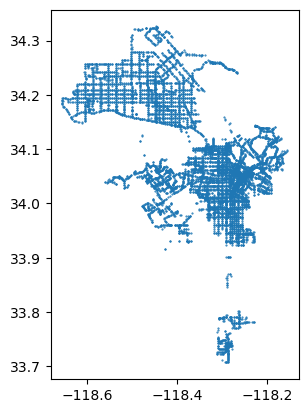

In [42]:
#plot as check
transit_stops.plot(marker='.',markersize=1)

### Trying to get a metric of density of transit stops/block group

In [43]:
#What is the best column indentifier for a block group?
cityblockgroups.head()

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
2456,2457,2742023,274202,BG 3,1.045276e+06,4082.112116,"POLYGON ((-118.46464 33.97641, -118.46508 33.9..."
2449,2450,2739025,273902,BG 5,5.131686e+06,9166.983856,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713..."
2448,2449,2739024,273902,BG 4,1.861628e+06,6284.133027,"POLYGON ((-118.46565 33.97974, -118.46587 33.9..."
2447,2448,2739023,273902,BG 3,1.218168e+06,4851.582209,"POLYGON ((-118.46315 33.98615, -118.46310 33.9..."
2435,2436,2735023,273502,BG 3,4.868382e+06,10124.770714,"POLYGON ((-118.47672 33.98746, -118.47506 33.9..."


I will use "BG20" as my block group unique identifier. 

In [44]:
#join transit data with cityblockgroup data
transit_bg = gpd.sjoin(cityblockgroups,transit_stops)
#display
transit_bg.sample(3)

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,index_right,stopid,stopname
1927,1928,2325004,232500,BG 4,1.492098e+06,4988.085895,"POLYGON ((-118.31484 33.98912, -118.31495 33.9...",688,305588.0,54th & Van Ness Ave.
928,929,1435003,143500,BG 3,2.841772e+06,9293.847581,"POLYGON ((-118.40521 34.14855, -118.40627 34.1...",11011,18223.0,Moorpark / Bellaire
1305,1306,1998022,199802,BG 2,1.795583e+06,6527.645920,"POLYGON ((-118.20901 34.07022, -118.21030 34.0...",742,305733.0,Broadway & Griffin Ave.


In [45]:
#Use valuecounts to get the number of unique stops per block group
transit_bg_count= transit_bg.value_counts(['BG20']).reset_index(name='stop_count')
#display
transit_bg_count.head()

,BG20,stop_count
0,2074001,177
1,2077122,79
2,2079021,67
3,2240201,53
4,2077111,49


Now I have a dataframe that has the number of transit stops per block group.

In [46]:
#Basic statistics on the number of transit stops/block group
transit_bg_count.describe()

,stop_count
count,2274.000000
mean,4.500000
std,6.000165
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,177.000000


array([[<AxesSubplot: title={'center': 'stop_count'}>]], dtype=object)

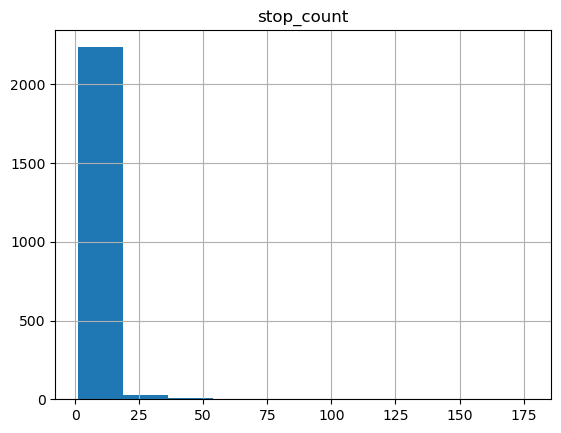

In [47]:
#plot a histogram
transit_bg_count.hist(bins=10)

What block group has 177 stops? Is that accurate?

In [48]:
#find the block group ID where # of stops = 177(max)
transit_bg_count.loc[transit_bg_count['stop_count'] == 177]

,BG20,stop_count
0,2074001,177


In [73]:
#find the geography of that block group
some_values = ['2074001']
maxbg = transit_bg.loc[transit_bg['BG20'].isin(some_values)]
maxbg.head(1)

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,index_right,stopid,stopname
1424,1425,2074001,207400,BG 1,9.358166e+06,15170.87179,"POLYGON ((-118.23805 34.05107, -118.23971 34.0...",6424,10493.0,1st / Judge John Aiso


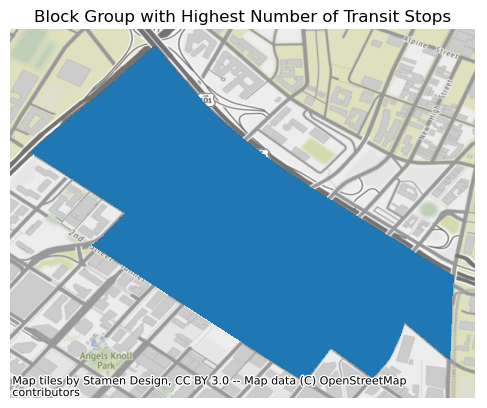

In [76]:
#plot it
fig,ax = plt.subplots(figsize=(6,6))
ax1=maxbg.plot(ax=ax)

#Format plot.
ax.axis('off')
ax.set_title('Block Group with Highest Number of Transit Stops')
ctx.add_basemap(ax, crs=4326)

This is right in downtown Los Angeles, so it does make sense as the block group with the most transit stops.

I want to add transit_bg_count back to my larger dataframe so that I have the spatial data included. 

In [87]:
#cityblockgroups['Stops_in_BG'] = pd.Series(dtype='int')


#for i in cityblockgroups['BG20']:
 #   if i == transit_bg_count['BG20']:
  #      cityblockgroups['Stops_in_BG'] = cityblockgroups['Stops_in_BG'].replace([i], transit_bg_count['stop_count'])
   # else:
    #    df['column_name'] = df['column_name'].replace([i], 'UNM')
     

^Struggling wiht figuring out how to do this, wil come back to it.

## Part 2: Identifying Block Groups with Walking Access to Transit Stops

In this section I will be following Monisha's steps to create buffers and identify which block groups are within/touching these buffers.

1) Create various walking distance buffers around all transit stops
2) Determine which census blocks are within these buffers. 

Since the walking distance calculations will be based in meters, I'll first have to convert the CRS of all geodataframes to EPSG 6423, which is the meter-based CRS for Los Angeles County. 

In [50]:
#drop NaN values form transit_stops
transit_stops.dropna(inplace=True)

# Create a new geodataframe of chain locations that is in a projection that accurately calculates things in meters.
transit_projection=transit_stops.to_crs('epsg:6423')

# Read the geojson file that Lucy created this week to get data on census block group demographics.
seniors=gpd.read_file('Percent_Senior_Basemap.geojson')

# Create a new geodataframe of blok groups that is in a projection that accurately calculates things in meters.
seniors_projection=seniors.to_crs('epsg:6423')

Now, I create  a short walking distance buffer around the transit stops: 1/4 mile and 1/8 mile. For grocery stores we also considered 1/2 mile, but considering you have to walk after getting off another stop that could end up being a lot of mileage for folks using transit.

In [51]:
# Create a new geodataframe that will contain my 1/4 mile buffers. 
transit_buffer_025=transit_projection

# Add a new column (walkshed) that contains a 402.336 meter (1/4 mile) buffer around each point. 
transit_buffer_025['walkshed'] = transit_buffer_025.buffer(402.336)

# Make my new buffer column the primary geometry for the geodataframe. 
transit_buffer_025=transit_buffer_025.set_geometry('walkshed')

In [52]:
# Create a new geodataframe that will contain my 1/8 mile buffers. 
transit_buffer_0125=transit_projection

# Add a new column (walkshed) that contains a 1/8 mile buffer around each point. 
transit_buffer_0125['walkshed'] = transit_buffer_0125.buffer(201.168)

# Make my new buffer column the primary geometry for the geodataframe. 
transit_buffer_0125=transit_buffer_0125.set_geometry('walkshed')

Map the buffers to enure it worked.

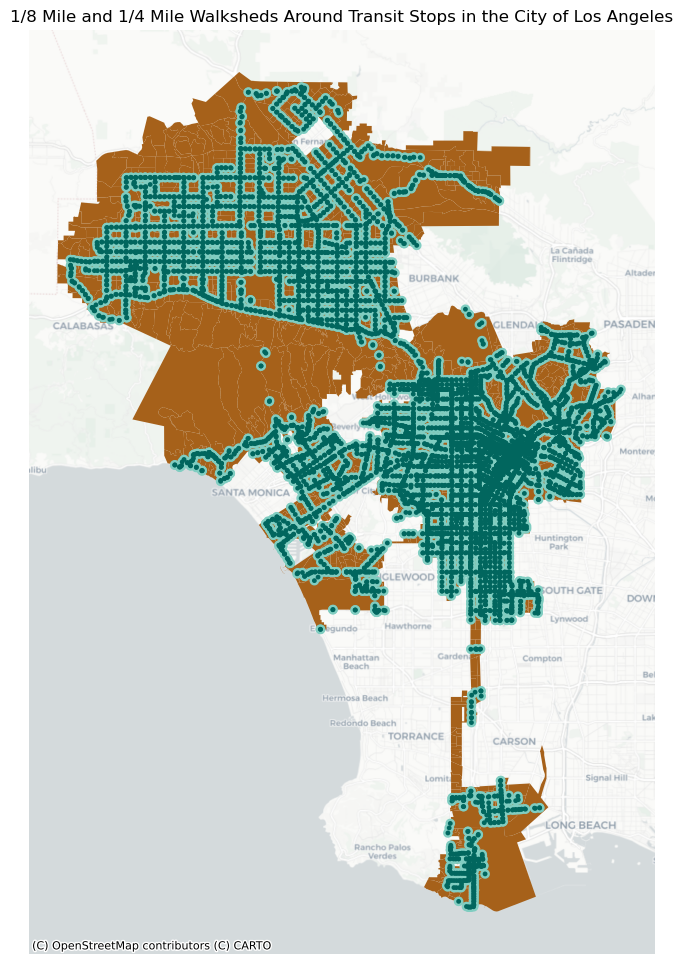

In [53]:
#Plot transit stop locations and walkshed buffers.
fig,ax = plt.subplots(figsize=(12,12))
#ax1=transit_projection.plot(ax=ax, zorder=4, markersize=3, color='yellow')
ax2=transit_buffer_0125.plot(ax=ax, zorder=3, color='#01665e')
ax3=transit_buffer_025.plot(ax=ax, zorder=2, color='#80cdc1')
ax4=seniors_projection.plot(ax=ax, zorder=1, color='#a6611a')

ax.axis('off')
ax.set_title('1/8 Mile and 1/4 Mile Walksheds Around Transit Stops in the City of Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.savefig('transitbuffers.png')

Now we'll figure out which block groups touch these buffers. Again, this overestimates access, because not all seniors will live within the walkshed of the transit stop.

In [54]:
# Make dataset easier to work with by keeping just columns of interest.
seniors_clean=seniors_projection[['BG20','FIPS','Square Miles', 'Total Pop','Total Senior Pop','Pop Density', 'Pct Seniors','geometry']].copy()

seniors_clean.head(2)

,BG20,FIPS,Square Miles,Total Pop,Total Senior Pop,Pop Density,Pct Seniors,geometry
0,2742023,060372742023,0.403581,740,13,32.0,1.756757,"POLYGON ((1957062.422 552945.617, 1957021.289 ..."
1,2739025,060372739025,1.981346,763,158,80.0,20.707733,"MULTIPOLYGON (((1956301.364 553742.388, 195644..."


Now create a copy of this geodataframe that contains each census block group's centroid and treats this point as the geodataframe's primary geography.

In [55]:
# Create a new dataframe to store information about grocery store access to a census block group's centroid.
seniors_centroids=seniors_clean

# Create a centroid column with a geopandas calculation.
seniors_centroids['centroid']=seniors_centroids.centroid

# Make my new centroid column the primary geometry for the geodataframe. 
seniors_centroids=seniors_centroids.set_geometry('centroid')

Join the two buffer geodataframs to my original census block group dataframe, which will produce information about which census block groups intersect with a grocery store walkshed.

First join information about the 0.125 mile buffers to my census block groups.


In [56]:
#Join in the geodataframe of 0.125 mile buffers. 
seniors_buffered=seniors_clean.sjoin(transit_buffer_0125, how="left")

#Remove duplicate BG caused by doing a left join.
seniors_buffered = seniors_buffered.drop_duplicates(subset='BG20', keep="first")

seniors_buffered.head(3)

,BG20,FIPS,Square Miles,Total Pop,Total Senior Pop,Pop Density,Pct Seniors,geometry_left,centroid,index_right,stopid,stopname,geometry_right
0,2742023,060372742023,0.403581,740,13,32.0,1.756757,"POLYGON ((1957062.422 552945.617, 1957021.289 ...",POINT (1957074.381 553168.110),7621.0,12689.0,Pacific / Hurricane,POINT (1957271.037 552869.577)
1,2739025,060372739025,1.981346,763,158,80.0,20.707733,"MULTIPOLYGON (((1956301.364 553742.388, 195644...",POINT (1956638.060 553535.355),489.0,424389.0,Pacific Ave & Washington Blvd (Departing),POINT (1957002.784 553258.138)
2,2739024,060372739024,0.718775,998,100,139.0,10.020040,"POLYGON ((1956970.245 553315.644, 1956950.061 ...",POINT (1956864.583 553677.484),489.0,424389.0,Pacific Ave & Washington Blvd (Departing),POINT (1957002.784 553258.138)


In [57]:
#Drop columns that we don't need.
seniors_buffered=seniors_buffered.drop(columns=['index_right'])

#Rename geometry of joined column to be more meaningful.
seniors_buffered.rename(columns = {'geometry_left' : 'buffer_geo_0125', 'geometry_right':'geometry',
                                  'stop_name' : 'stop_name_0125', 'stopid' : 'stopid_type_0125'}, inplace = True)

#Set the blockgroup boundaries to be the geography.
seniors_buffered=seniors_buffered.set_geometry('geometry')

In [58]:
seniors_buffered.head()

,BG20,FIPS,Square Miles,Total Pop,Total Senior Pop,Pop Density,Pct Seniors,buffer_geo_0125,centroid,stopid_type_0125,stopname,geometry
0,2742023,060372742023,0.403581,740,13,32.0,1.756757,"POLYGON ((1957062.422 552945.617, 1957021.289 ...",POINT (1957074.381 553168.110),12689.0,Pacific / Hurricane,POINT (1957271.037 552869.577)
1,2739025,060372739025,1.981346,763,158,80.0,20.707733,"MULTIPOLYGON (((1956301.364 553742.388, 195644...",POINT (1956638.060 553535.355),424389.0,Pacific Ave & Washington Blvd (Departing),POINT (1957002.784 553258.138)
2,2739024,060372739024,0.718775,998,100,139.0,10.020040,"POLYGON ((1956970.245 553315.644, 1956950.061 ...",POINT (1956864.583 553677.484),424389.0,Pacific Ave & Washington Blvd (Departing),POINT (1957002.784 553258.138)
3,2739023,060372739023,0.470335,1098,240,510.0,21.857923,"POLYGON ((1957205.091 554025.253, 1957209.466 ...",POINT (1957031.745 553943.931),5630.0,Venice / Washington,POINT (1957078.398 554178.709)
4,2735023,060372735023,1.879684,923,69,37.0,7.475623,"POLYGON ((1955951.452 554176.203, 1956105.730 ...",POINT (1956267.990 554077.892),168,MAIN SB & VENICE WAY NS,POINT (1956504.170 554167.293)


Repeat this process with the 0.25 mile buffers.

In [59]:
#Join in the geodataframe of 0.25 mile buffers. 
seniors_buffered2=seniors_buffered.sjoin(transit_buffer_025, how="left")

#Remove duplicate BG caused by doing a left join.
seniors_buffered2 = seniors_buffered2.drop_duplicates(subset='BG20', keep="first")

#Drop columns that we don't need.
seniors_buffered2=seniors_buffered2.drop(columns=['index_right'])

#Rename geometry of joined column to be more meaningful.
seniors_buffered2.rename(columns = {'geometry_left' : 'buffer_geo_025', 'geometry_right':'geometry',
                                  'stop_name' : 'stop_name_025', 'stopid' : 'stopid_type_0125'}, inplace = True)

#Set the blockgroup boundaries to be the geography.
seniors_buffered2=seniors_buffered2.set_geometry('geometry')


In [60]:
seniors_buffered2.head()

,BG20,FIPS,Square Miles,Total Pop,Total Senior Pop,Pop Density,Pct Seniors,buffer_geo_0125,centroid,stopid_type_0125,stopname_left,buffer_geo_025,stopid_type_0125,stopname_right,geometry
0,2742023,060372742023,0.403581,740,13,32.0,1.756757,"POLYGON ((1957062.422 552945.617, 1957021.289 ...",POINT (1957074.381 553168.110),12689.0,Pacific / Hurricane,POINT (1957271.037 552869.577),486111.0,Pacific Ave & Lighthouse St (Northbound),POINT (1957443.370 552584.765)
1,2739025,060372739025,1.981346,763,158,80.0,20.707733,"MULTIPOLYGON (((1956301.364 553742.388, 195644...",POINT (1956638.060 553535.355),424389.0,Pacific Ave & Washington Blvd (Departing),POINT (1957002.784 553258.138),12687.0,Pacific / Fleet,POINT (1957220.389 552948.567)
2,2739024,060372739024,0.718775,998,100,139.0,10.020040,"POLYGON ((1956970.245 553315.644, 1956950.061 ...",POINT (1956864.583 553677.484),424389.0,Pacific Ave & Washington Blvd (Departing),POINT (1957002.784 553258.138),12687.0,Pacific / Fleet,POINT (1957220.389 552948.567)
3,2739023,060372739023,0.470335,1098,240,510.0,21.857923,"POLYGON ((1957205.091 554025.253, 1957209.466 ...",POINT (1957031.745 553943.931),5630.0,Venice / Washington,POINT (1957078.398 554178.709),5630.0,Venice / Washington,POINT (1957078.398 554178.709)
4,2735023,060372735023,1.879684,923,69,37.0,7.475623,"POLYGON ((1955951.452 554176.203, 1956105.730 ...",POINT (1956267.990 554077.892),168,MAIN SB & VENICE WAY NS,POINT (1956504.170 554167.293),168,MAIN SB & VENICE WAY NS,POINT (1956504.170 554167.293)


Use the information that has been joined in to create a grocery_walkable column that returns a 0 if the census block group does not intersect any grocery store walkshed, a 1 if the block group intersects a 0.25 mile walkshed, and a 2 if the block group intersects a 0.125 mile walkshed.

In [61]:
seniors_buffered2['stop_walkable']= '1: No walkable transit stop'
seniors_buffered2.loc[seniors_buffered2['buffer_geo_025'].notnull(),
                      'stop_walkable'] = '2: Transit stop within 1/4 mile'
seniors_buffered2.loc[seniors_buffered2['buffer_geo_0125'].notnull(),
                      'stop_walkable'] = '3: Grocery store within 1/8 mile'

Make a map that colors block groups based on their walking access to grocery stores.

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

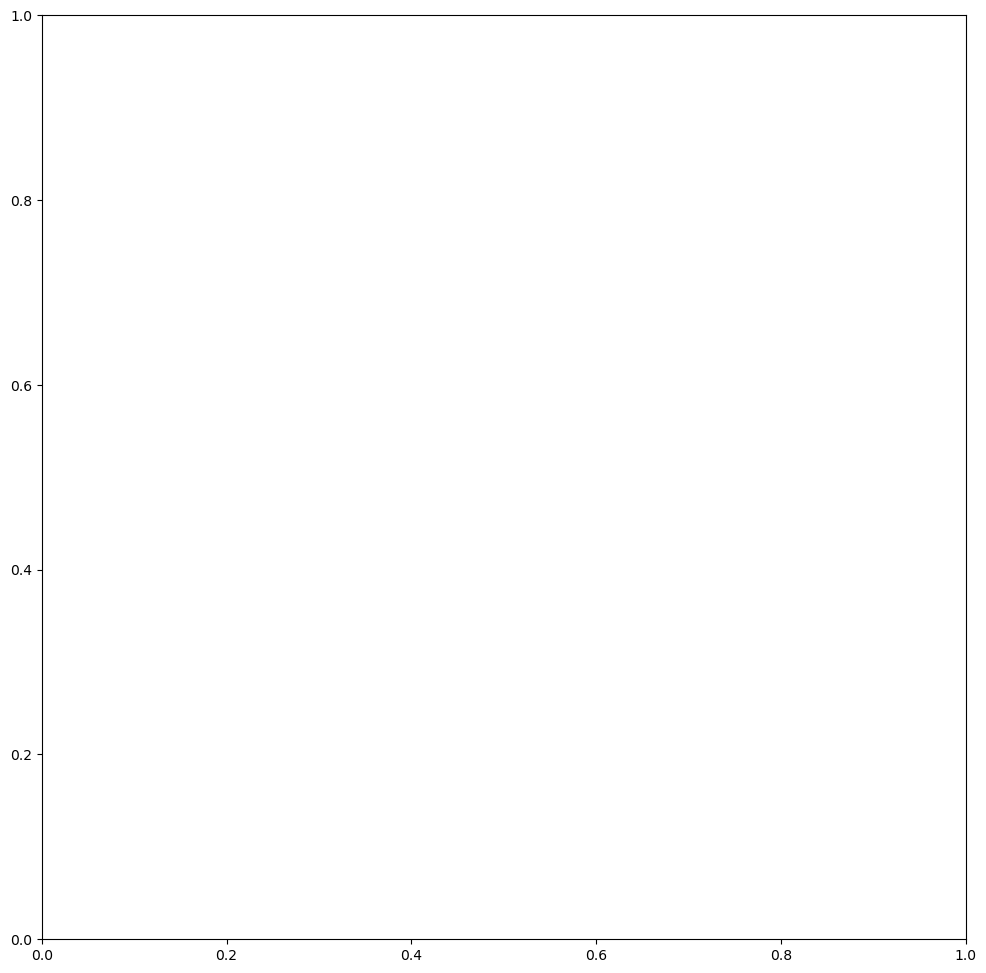

In [62]:
#Plot the block groups that allegedly have access and the grocery store locations.

# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'1: No walkable transit stop': '#a6611a',
 '2: Transit Stop within 1/4 mile': '#80cdc1',
 '3: Transit Stop within 1/8 mile': '#01665e'}

seniors_buffered2["colors"] = seniors_buffered2["stop_walkable"].map(color_dict)

fig,ax = plt.subplots(figsize=(12,12))
ax = seniors_buffered2.plot(ax=ax, color = seniors_buffered2["colors"])

# Add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys())
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Transit Stop Access from Nearest Point in Census Block Group')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.savefig('transit_intersections.png')

Repeat all of the steps above but by joining my grocery store walkshed buffers to a geodataframe that uses each census block group's centroid as its primary geometry. This will effectively only join buffers that contain the centroid (rather than buffers that intersect the entire census block group).

Like before, I begin by joining the 0.125 mile buffers.

In [ ]:
#Join in the geodataframe of 0.125 mile buffers. 
seniors_centroid_buffered=seniors_centroids.sjoin(transit_buffer_0125, how="left")

#Remove duplicate BG caused by doing a left join.
seniors_centroid_buffered = seniors_centroid_buffered.drop_duplicates(subset='BG20', keep="first")

#Drop columns that we don't need.
seniors_centroid_buffered=seniors_centroid_buffered.drop(columns=['index_right'])

#Rename geometry of joined column to be more meaningful.
seniors_centroid_buffered.rename(columns = {'geometry_left' : 'geometry', 'geometry_right':'buffer_geo_0125',
                                  'stop_name' : 'stop_name_0125', 'stopid' : 'stopid_type_0125'}, inplace = True)

#Set the blockgroup boundaries to be the geography.
seniors_centroid_buffered=seniors_centroid_buffered.set_geometry('centroid')

Next I join in the 0.25 mile buffers.

In [ ]:
#Join in the geodataframe of 0.25 mile buffers. 
seniors_centroid_buffered2=seniors_centroids.sjoin(transit_buffer_025, how="left")

#Remove duplicate BG caused by doing a left join.
seniors_centroid_buffered2 = seniors_centroid_buffered2.drop_duplicates(subset='BG20', keep="first")

seniors_centroid_buffered2.head(2)

In [ ]:

#Drop columns that we don't need.
seniors_centroid_buffered2=seniors_centroid_buffered2.drop(columns=['index_right'])

#Rename geometry of joined column to be more meaningful.
#not sure I hav geometry left vs geometry right correct*************
seniors_centroid_buffered2.rename(columns = {'geometry_left' : 'buffer_geo_025', 'geometry_right':'geometry',
                                  'stop_name' : 'stop_name_025', 'stopid' : 'stopid_type_025'}, inplace = True)

#Set the blockgroup boundaries to be the geography.
seniors_centroid_buffered2=seniors_centroid_buffered2.set_geometry('centroid')

Finally I use the columns that have been joined to category each census block group as having a centroid that is either 1) Outside of all transit stop buffers, 2) Within a 0.25 mile buffer but not the 0.125 mile buffer of a transit stop, or 3) Within a 0.125 mile buffer of a transit stop.

In [ ]:
seniors_centroid_buffered2['stop_walkable']= '1: No walkable transit stop'
seniors_centroid_buffered2.loc[seniors_centroid_buffered2['buffer_geo_025'].notnull(),
                               'stop_walkable'] = '2: Transit stop within 1/4 mile'
seniors_centroid_buffered2.loc[seniors_centroid_buffered2['buffer_geo_0125'].notnull(), 
                               'stop_walkable'] = '3: Grocery store within 1/8 mile'

Finally, map block groups, categorized by their walk access to transit stops.

In [ ]:
#Plot the block groups that allegedly have access and the transit stop locations.

# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'1: No walkable grocery store': '#a6611a',
 '2: Grocery store within 1/4 mile': '#80cdc1',
 '3: Grocery store within 1/8 mile': '#01665e'}

seniors_centroid_buffered2["colors"] = seniors_centroid_buffered2["stop_walkable"].map(color_dict)


fig,ax = plt.subplots(figsize=(12,12))
ax = seniors_centroid_buffered2.plot(ax=ax, color = seniors_centroid_buffered2["colors"])

# Add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys())
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Transit Stop Access from Centroid of Census Block Group')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.savefig('transit_centroids.png')

### Relating Walkable Areas to Senior Population

We can use this information to do some basic calculations about how likely Seniors are to live within walking distance, and whether they have worse (or better) acess than the general population of Los Angeles.

First, I want to create a new table that contains calculations about what percentage of Seniors and All Residents live within walking distance of a grocery store.

In [ ]:
# Sum up all of the data for all of the block groups in each category.
senior_sums = seniors_centroid_buffered2.groupby(by='stop_walkable').sum()

# Keep just the columns that we're interested in.
senior_sums=senior_sums[['Square Miles','Total Pop','Total Senior Pop']]

# Create calculated columns. 
senior_sums['Pct of All Population']=senior_sums['Total Pop']/(senior_sums['Total Pop'].sum())
senior_sums['Pct of Seniors']=senior_sums['Total Senior Pop']/(senior_sums['Total Senior Pop'].sum())
senior_sums

Create rows for all residents for final table.


In [ ]:
# Create new table with just level of walk access and percentage of all residents living in that type of area. 
senior_sums_all=senior_sums[['stop_walkable','Pct of All Population']].copy()

# Rename columns so that this will merge with table of Seniors. 
senior_sums_all.rename(columns = {'stop_walkable' : 'Walking Access', 'Pct of All Population':'Percent'}, inplace = True)

# Create a new column that will preserve the information that this data relates to All Residents. 
senior_sums_all['Population'] = 'All Residents'

# Take a look at 3 rows that were produced.
senior_sums_all